In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
gt = pd.read_csv('answer_dummy.csv')
pred = pd.read_csv('submission.csv')

In [11]:
def calc_IoU(A,B):
    AorB = np.logical_or(A,B).astype('int')
    AandB = np.logical_and(A,B).astype('int')
    IoU = AandB.sum() / AorB.sum()
    return IoU

def rle_to_mask(rle_list, SHAPE):
    tmp_flat = np.zeros(SHAPE[0]*SHAPE[1])
    if len(rle_list) == 1:
        mask = np.reshape(tmp_flat, SHAPE).T
    else:
        strt = rle_list[::2]
        length = rle_list[1::2]
        for i,v in zip(strt,length):
            tmp_flat[(int(i)-1):(int(i)-1)+int(v)] = 255
        mask = np.reshape(tmp_flat, SHAPE).T
    return mask

def calc_IoU_threshold(data):
    # Note: This rle_to_mask should be called before loop below for speed-up! We currently implement here to reduse memory usage.
    mask_gt = rle_to_mask(data['EncodedPixels_gt'].split(), (int(data['Height']), int(data['Width'])))
    mask_pred = rle_to_mask(data['EncodedPixels_pred'].split(), (int(data['Height']), int(data['Width'])))
    return calc_IoU(mask_gt, mask_pred)

In [12]:
def evaluation(gt_df, pred_df):
    eval_df = pd.merge(gt_df, pred_df, how='outer', on=['ImageId', 'CategoryId'], suffixes=['_gt', '_pred'])
    eval_df = eval_df[['ImageId', 'EncodedPixels_gt', 'Height_gt', 'Width_gt', 'CategoryId', 'EncodedPixels_pred']]
    eval_df = eval_df.rename(columns={'Height_gt': 'Height',
                            'Width_gt': 'Width'})
    # IoU for True Positive
    idx_ = eval_df['EncodedPixels_gt'].notnull() & eval_df['EncodedPixels_pred'].notnull()
    IoU = eval_df[idx_].apply(calc_IoU_threshold, axis=1)

    # False Positive
    fp = (eval_df['EncodedPixels_gt'].isnull() & eval_df['EncodedPixels_pred'].notnull()).sum()

    # False Negative
    fn = (eval_df['EncodedPixels_gt'].notnull() & eval_df['EncodedPixels_pred'].isnull()).sum()

    threshold_IoU = [0.5]
    scores = []
    for th in threshold_IoU:
        # True Positive
        tp = (IoU > th).sum()
        maybe_fp = (IoU <= th).sum()

        # False Positive (not Ground Truth) + False Positive (under IoU threshold)
        fp_IoU = fp + maybe_fp

        # Calculate evaluation score
        score = tp / (tp + fp_IoU + fn)
        scores.append(score)
        print(f"Threshold: {th}, Precision: {score}, TP: {tp}, FP: {fp_IoU}, FN: {fn}")

    mean_score = sum(scores) / len(threshold_IoU)
    print(f"Mean precision score: {mean_score}")
    return mean_score

In [13]:
evaluation(gt, pred)

Threshold: 0.5, Precision: 0.5, TP: 50, FP: 50, FN: 0
Mean precision score: 0.5


0.5

In [6]:
gt['EncodedPixels'][0]

'242656 82 243447 117 244242 133 245038 143 245835 150 246631 162 247427 174 248223 185 249018 196 249815 204 250613 211 251411 215 252209 218 253008 221 253807 223 254606 225 255405 228 256204 230 257003 232 257802 234 258600 237 259399 239 260199 240 260998 241 261797 243 262597 243 263397 243 264196 244 264996 244 265796 245 266595 246 267395 246 268195 246 268995 246 269794 247 270594 247 271394 246 272194 246 272994 246 273794 246 274593 246 275393 246 276193 246 276993 245 277793 245 278593 244 279393 244 280193 244 280993 243 281793 243 282593 242 283393 241 284193 241 284993 240 285793 239 286593 239 287394 237 288194 237 288994 237 289794 236 290594 236 291394 235 292194 235 292995 233 293795 233 294595 233 295395 233 296195 233 296995 233 297795 232 298595 232 299396 231 300196 231 300996 231 301796 231 302596 231 303396 230 304196 230 304996 230 305796 230 306596 230 307396 229 308196 229 308996 229 309796 229 310596 229 311396 229 312196 229 312996 229 313796 229 314596 228

In [7]:
i = 0
mask = rle_to_mask(gt['EncodedPixels'][i].split(), (int(gt['Height'][i]), int(gt['Width'][i])))
print(mask)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


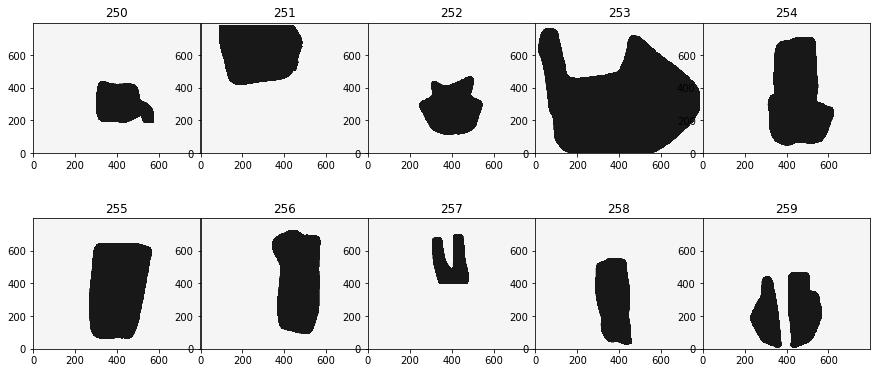

In [8]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(10):

    axs[i].contourf(rle_to_mask(gt['EncodedPixels'][i].split(), (int(gt['Height'][i]), int(gt['Width'][i]))),5,cmap=plt.cm.Greys)
    axs[i].set_title(str(250+i))